# Importing the libraries and seting the paths

In [22]:
from utils import open_nea_table, download_nea_table
from mass_year import mass_vs_year_plot, planet_discovery_stat
import pandas as pd
import numpy as np
import os
import sys
from datetime import date
import math

If needed to update the NEA table then first run  "download_nea_table"

In [23]:
nea_full_table = open_nea_table()
nea_full_table.head(3)

/home/vadibekyan/my_github/ExoPLots/utils.py:52: DtypeWarning: Columns (65,187) have mixed types. Specify dtype option on import or set low_memory=False.
  nea_full_table = pd.read_csv(table_directory)


,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,gaia_id,default_flag,pl_refname,sy_refname,...,sy_jmagerr1,sy_jmagerr2,sy_jmagstr,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmagstr,sy_kmag,sy_kmagerr1,sy_kmagerr2
0,OGLE-TR-10 b,b,OGLE-TR-10,NaN,NaN,TIC 130150682,Gaia DR2 4056443366649948160,1,<a refstr=TORRES_ET_AL__2008 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,NaN,NaN,13.692,13.314,0.121,-0.121,13.314&plusmn;0.121,12.856,NaN,NaN
1,BD-08 2823 c,c,BD-08 2823,NaN,HIP 49067,TIC 33355302,Gaia DR2 3770419611540574080,1,<a refstr=HEBRARD_ET_AL__2010 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.020,-0.020,7.96&plusmn;0.02,7.498,0.047,-0.047,7.498&plusmn;0.047,7.323,0.021,-0.021
2,HR 8799 c,c,HR 8799,HD 218396,HIP 114189,TIC 245368902,Gaia DR2 2832463659640297472,1,<a refstr=MAROIS_ET_AL__2008 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.027,-0.027,5.383&plusmn;0.027,5.280,0.018,-0.018,5.280&plusmn;0.018,5.240,0.018,-0.018


In [24]:
nea_full_table.columns.values

array(['pl_name', 'pl_letter', 'hostname', 'hd_name', 'hip_name',
       'tic_id', 'gaia_id', 'default_flag', 'pl_refname', 'sy_refname',
       'disc_pubdate', 'disc_year', 'discoverymethod', 'disc_locale',
       'disc_facility', 'disc_instrument', 'disc_telescope',
       'disc_refname', 'ra', 'rastr', 'dec', 'decstr', 'glon', 'glat',
       'elon', 'elat', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2',
       'pl_orbperlim', 'pl_orbperstr', 'pl_orblpererr1', 'pl_orblper',
       'pl_orblpererr2', 'pl_orblperlim', 'pl_orblperstr', 'pl_orbsmax',
       'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim',
       'pl_orbsmaxstr', 'pl_orbincl', 'pl_orbinclerr1', 'pl_orbinclerr2',
       'pl_orbincllim', 'pl_orbinclstr', 'pl_orbtper', 'pl_orbtpererr1',
       'pl_orbtpererr2', 'pl_orbtperlim', 'pl_orbtperstr', 'pl_orbeccen',
       'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim',
       'pl_orbeccenstr', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2',
       'pl_eqtlim', 'pl_eqtstr', 'pl_oc

In [25]:
relevant_columns = ['pl_name', 'pl_letter', 'hostname', 'gaia_id', 'ra', 'dec', 'disc_year', 'discoverymethod',
       'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 
       'pl_orbsmax', 'pl_orbsmaxerr1','pl_orbsmaxerr2', 
       'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 
       'pl_masse', 'pl_masseerr1', 'pl_masseerr2', 
       'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 
       'pl_bmassprov', 
       'pl_msinie', 'pl_msinieerr1', 'pl_msinieerr2',
       'st_teff', 'st_met', 'st_lum', 'st_logg', 'st_age', 'st_mass', 'st_rad', 'sy_vmag', 'sy_gaiamag', 'sy_plx',
       'ttv_flag', 'tran_flag', 'rv_flag']

In [26]:
nea_relevant = nea_full_table[relevant_columns]
nea_relevant.to_csv('nea_relevant.csv', index = False)

In [27]:
#nea_relevant[['pl_rade', 'pl_bmasse', 'disc_year', 'discoverymethod']].head(20)

In [28]:
print(np.pi)

3.141592653589793


R-M relation should be taken considering Teff, radius, and orbital period

In [35]:
tmp = nea_relevant[['pl_rade', 'st_teff', 'pl_bmasse', 'pl_orbper', 'st_rad', 'sy_vmag', 'sy_gaiamag', 'sy_plx', 'pl_orbsmax', 'st_mass']]
tmp = tmp[tmp.pl_bmasse == tmp.pl_bmasse]
tmp = tmp[tmp.pl_rade > 0]
tmp = tmp[tmp.st_teff > 0]
print (tmp)
tmp['st_mass'].isna().sum()

      pl_rade  st_teff   pl_bmasse  pl_orbper  st_rad  sy_vmag  sy_gaiamag  \
0      14.011   5950.0   197.04600   3.101278    1.17   16.006   15.684500   
7       2.800   5800.0   508.50000  12.333500    1.07   15.040   14.923400   
10      2.200   3900.0  1303.00000   5.901240    0.53   16.360   15.812300   
38     16.870   5941.0   271.74465   3.899052    1.93   12.006   11.939200   
39     21.633   6100.0   352.79130   2.175180    2.46   11.965   12.187900   
...       ...      ...         ...        ...     ...      ...         ...   
5438    1.240   3803.0     2.14000   2.769530    0.44    9.630    8.876041   
5440    4.570   3600.0    13.90000   3.336650    0.55   12.332   11.353700   
5442   18.046   6933.0  1430.17500   2.485533    1.53   14.718   14.563700   
5443   11.781   6202.0   953.49000   6.180235    1.59   11.237   11.254900   
5449   11.321   5144.0   310.83618  11.910100    0.79   13.004   12.760600   

         sy_plx  pl_orbsmax  st_mass  pl_orbsmax  
0      0.721

6

In [30]:
teff = 100
teff_err = None
teff_array = np.random.normal(teff, teff_err, 5) if teff_err is not None and teff_err == teff_err else teff
teff_array

100

# Mass discovery year plot

In [31]:
planet_discovery_stat()

-----  Some Stats -----
5463 planets discovered so far

1088 via Transiting/TTV methods
1043 via RV method
200 via Microlensing method
64 via Imaging method
35 by other methods
-----     End     ----


/home/vadibekyan/my_github/ExoPLots/utils.py:52: DtypeWarning: Columns (65,187) have mixed types. Specify dtype option on import or set low_memory=False.
  nea_full_table = pd.read_csv(table_directory)


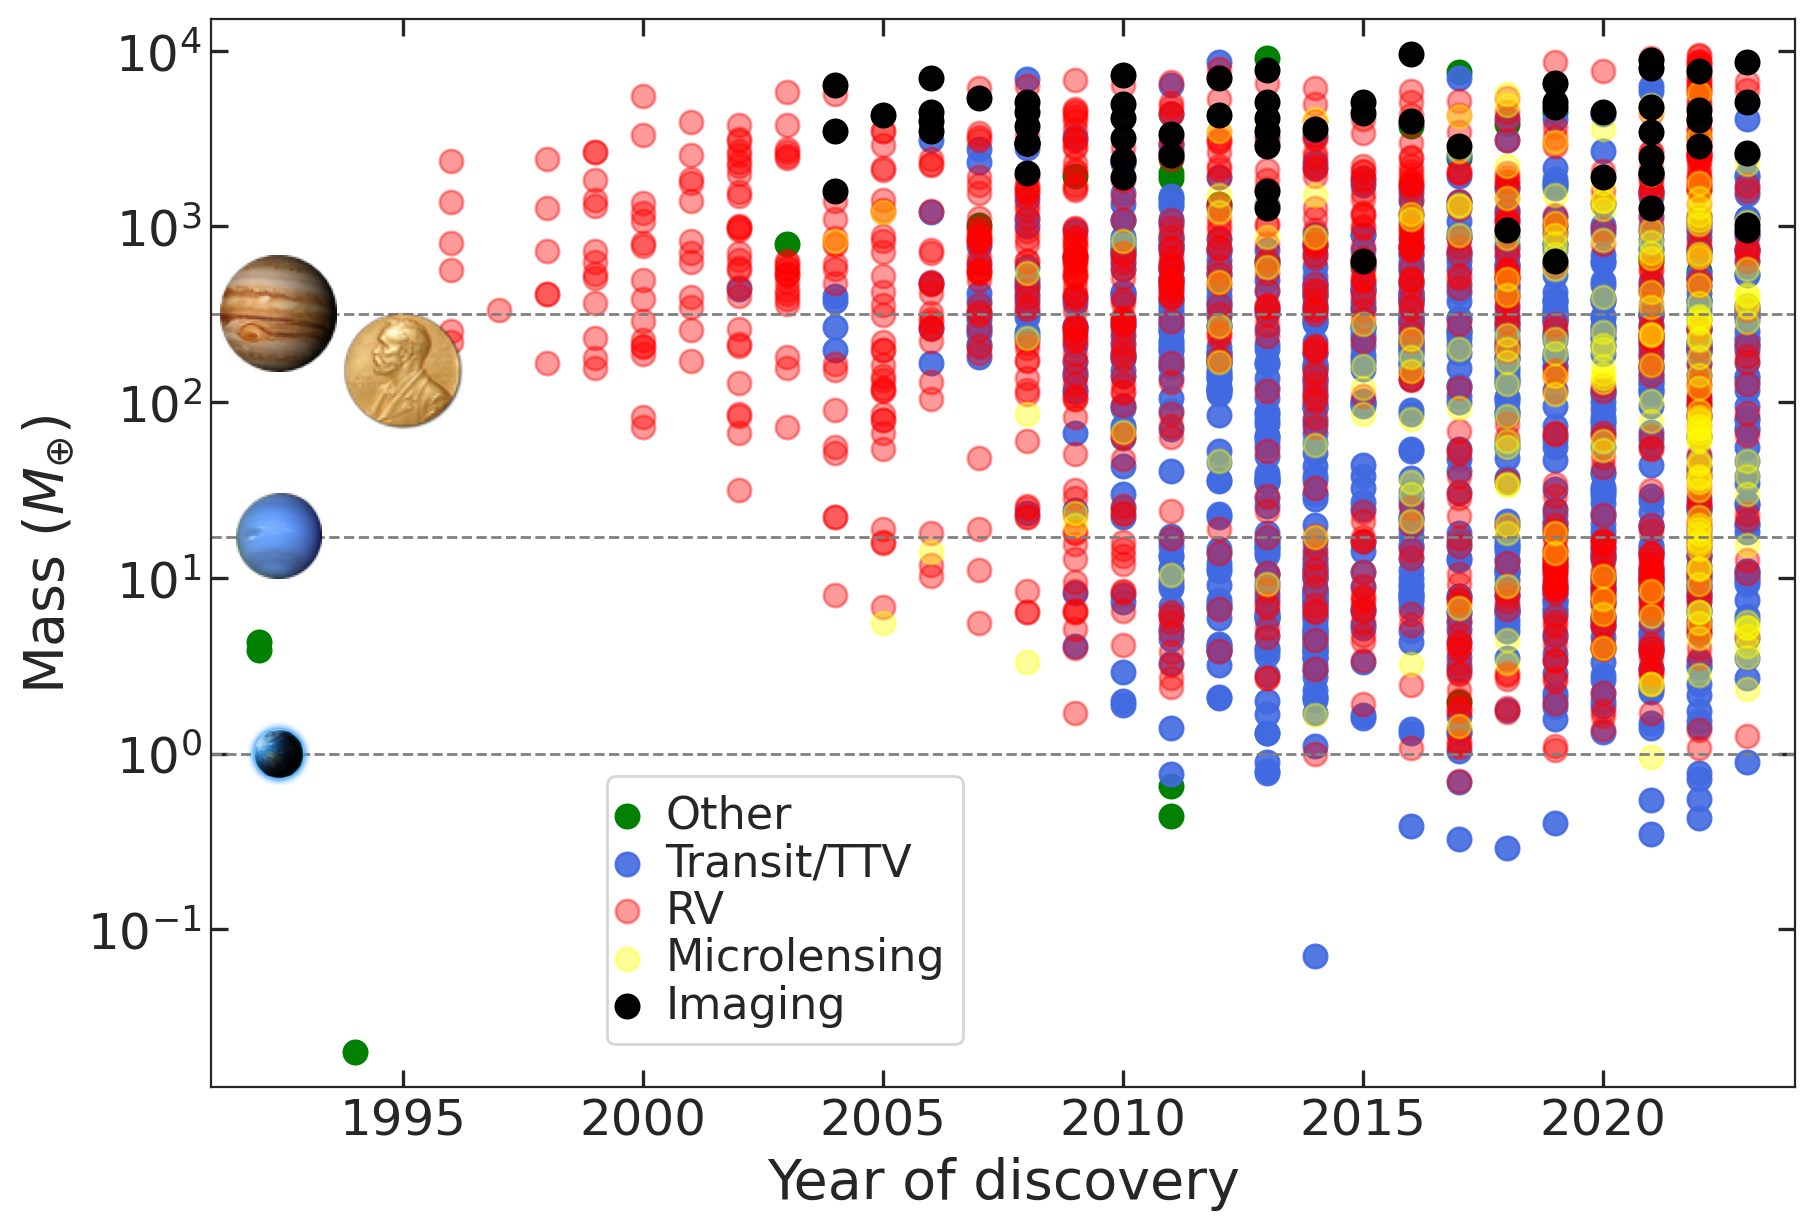

In [32]:
mass_vs_year_plot()

In [33]:
from PIL import Image

def change_resolution(input_path, output_path, scale):
    # Open the image
    image = Image.open(input_path)

    width, height = image.size
    print (width, height)

    new_width, new_height = int(width*scale), int(height*scale)

    # Resize the image
    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

    # Save the resized image
    resized_image.save(output_path)

# Example usage
#change_resolution('./ss_planet_images/pngaaa.com-267808.png', 'nobel.png', 0.11)
#change_resolution('./ss_planet_images/pngaaa.com-107985.png', './ss_planet_images/earth.png', 0.1)
#change_resolution('./ss_planet_images/pngaaa.com-107985.png', './ss_planet_images/earth.png', 0.1)
#change_resolution('./ss_planet_images/pngaaa.com-107985.png', './ss_planet_images/earth.png', 0.1)


The images are taken (and then resized) from pngaa.com under License of "Non-comercial Use"